# BlazeFace training

This notebook is an attempt to train BlazeFace on Pascal VOC dataset

In [1]:
import tensorflow as tf
import math
import os
import keras
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder_blazeface import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder_blazeface import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


## 0. Preliminary note

All places in the code where you need to make any changes are marked `TODO` and explained accordingly. All code cells that don't contain `TODO` markers just need to be executed.

## 1. Set the model configuration parameters

This section sets the configuration parameters for the model definition. The parameters set here are being used both by the `blazeface()` function that builds the BlazeFace model as well as further down by the constructor for the `SSDInputEncoder` object that is needed to run the training. Most of these parameters are needed to define the anchor boxes.

As mentioned above, the parameters set below are not only needed to build the model, but are also passed to the `SSDInputEncoder` constructor further down, which is responsible for matching and encoding ground truth boxes and anchor boxes during the training. In order to do that, it needs to know the anchor box parameters.

In [2]:
img_height = 128 # Height of the model input images
img_width = 128 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [[0.2, math.sqrt(0.2 * 0.43)], [0.43, math.sqrt(0.43 * 0.67), 0.67, math.sqrt(0.67 * 0.9), 0.9, math.sqrt(0.9 * 1)]]
aspect_ratios = [[1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]] # The anchor box aspect ratios
steps = [64, 128] # The space between two adjacent anchor box center points for each predictor layer.
offsets = None # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model

In [3]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = blazeface(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
#weights_path = 'checkpoint/blazeface_1class_wider_epoch-96_loss-6.1649_val_loss-1.9797.h5'

#model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### 2.2 Load a previously created model

If you have previously created and saved a model and would now like to load it, execute the next code cell. The only thing you need to do here is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function nor the anchor box or L2-normalization layer types are contained in the Keras core library, so we need to provide them to the model loader.

This next code cell assumes that you want to load a model that was created in 'training' mode. If you want to load a model that was created in 'inference' or 'inference_fast' mode, you'll have to add the `DecodeDetections` or `DecodeDetectionsFast` layer type to the `custom_objects` dictionary below.

In [4]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 128, 128, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 128, 128, 3)  0           input_mean_normalization[0][0]   
____________________________________________________________________________________________

In [5]:
# # TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'checkpoint/blazeface_1class_wider_epoch-96_loss-6.1649_val_loss-1.9797.h5'

# # We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                              'L2Normalization': L2Normalization,
                                              'compute_loss': ssd_loss.compute_loss})

NameError: name 'keras' is not defined

## 3. Set up the data generators for the training

Please download [FDDB dataset](http://vis-www.cs.umass.edu/fddb/) and extract into `data/FDDB/FDDB-folds` and `data/FDDB/originalPics`.

In [12]:
# from FDDB_to_csv import FDDB_to_csv

# # Combine annotation files
train_images_dir = "../BlazeFace/data/WIDER_train/images/"
val_images_dir = '../BlazeFace/data/WIDER_val/images/'
# annotation_dir = "./data/FDDB/FDDB-folds/"
train_anno_file = "./data/train_annos.csv"
# val_anno_file = "./data/FDDB/FDDB-val.csv"
val_anno_file = "./data/val_annos.csv"

# FDDB_to_csv(annotation_dir, images_dir, train_anno_file, 
#             val_anno_file, test_anno_file, train_ratio=.7, val_ratio=.2, seed=42)

In [13]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path='wider_train_new.h5')
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path='wider_val_new_v2.h5')

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Ground truth
train_labels_filename = train_anno_file
val_labels_filename   = val_anno_file

train_dataset.parse_csv(images_dir=train_images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=val_images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

# train_dataset.create_hdf5_dataset(file_path='fddb_train.h5',
#                                   resize=False,
#                                   variable_image_size=True,
#                                   verbose=True)

# val_dataset.create_hdf5_dataset(file_path='fddb_val.h5',
#                                 resize=False,
#                                 variable_image_size=True,
#                                 verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 12880/12880 [03:13<00:00, 66.60it/s]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loading images into memory: 100%|██████████| 3226/3226 [00:49<00:00, 65.66it/s]
[array([[  1.,   8., 524.,  20., 535.],
       [  1.,  13., 531.,  21., 544.],
       [  1.,  31., 528.,  39., 539.],
       [  1.,  40., 524.,  48., 533.],
       [  1.,  48., 531.,  59., 544.],
       [  1.,  57., 542.,  77., 564.],
       [  1.,  79., 524.,  85., 529.],
       [  1.,  83., 539., 100., 560.],
       [  1., 126., 534., 132., 541.],
       [  1., 135., 528., 142., 539.],
       [  1., 183., 535., 205., 559.],
       [  1., 222., 527., 235., 543.],
       [  1., 268., 529., 284., 554.],
       [  1., 288., 527., 296., 539.],
       [  1., 294., 526., 305., 539.],
       [  1., 304., 534., 315., 544.],
       [  1., 331., 542., 346., 564.],
       [  1., 362., 489., 368., 496.],
       [  1., 364., 539., 375., 552.],
       [  1., 376., 524., 386., 535.],
       [  1., 380., 544., 391., 559.],
       [  1., 390., 495., 396., 502.],
       [  1., 401., 517., 408., 526.],
       [  1., 407., 50

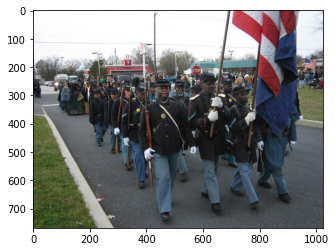

In [15]:
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(train_dataset.images[100])
plt.show()

In [16]:
# 3: Set the batch size.

batch_size = 27 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes16x16').output_shape[1:3],
                   model.get_layer('classes8x8').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()


p = next(train_generator)
for i in p:
    print(i.shape)

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

/home/blazeface_keras/ssd_encoder_decoder/ssd_input_encoder_blazeface.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  scales = np.array(scales)


(27, 128, 128, 3)
(27, 896, 14)
Number of images in the training dataset:	 12880
Number of images in the validation dataset:	  3226


In [17]:
p = next(train_generator)

for i in p:
    print(i.shape)

[[[123 117 104]
  [123 117 104]
  [123 117 104]
  ...
  [123 117 104]
  [123 117 104]
  [123 117 104]]

 [[123 117 104]
  [123 117 104]
  [123 117 104]
  ...
  [123 117 104]
  [123 117 104]
  [123 117 104]]

 [[123 117 104]
  [123 117 104]
  [123 117 104]
  ...
  [123 117 104]
  [123 117 104]
  [123 117 104]]

 ...

 [[230  92  90]
  [246  95  95]
  [247  99 100]
  ...
  [123 117 104]
  [123 117 104]
  [123 117 104]]

 [[236  92  92]
  [244  97  97]
  [243  97  97]
  ...
  [123 117 104]
  [123 117 104]
  [123 117 104]]

 [[235  92  92]
  [242  95  95]
  [239  93  93]
  ...
  [123 117 104]
  [123 117 104]
  [123 117 104]]]
(27, 128, 128, 3)
(27, 896, 14)


## 4. Set the remaining training parameters

We've already chosen an optimizer and set the batch size above, now let's set the remaining training parameters. I'll set one epoch to consist of 1,000 training steps. The next code cell defines a learning rate schedule that replicates the learning rate schedule of the original Caffe implementation for the training of the SSD300 Pascal VOC "07+12" model. That model was trained for 120,000 steps with a learning rate of 0.001 for the first 80,000 steps, 0.0001 for the next 20,000 steps, and 0.00001 for the last 20,000 steps. If you're training on a different dataset, define the learning rate schedule however you see fit.

I'll set only a few essential Keras callbacks below, feel free to add more callbacks if you want TensorBoard summaries or whatever. We obviously need the learning rate scheduler and we want to save the best models during the training. It also makes sense to continuously stream our training history to a CSV log file after every epoch, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Finally, we'll also add a callback that makes sure that the training terminates if the loss becomes `NaN`. Depending on the optimizer you use, it can happen that the loss becomes `NaN` during the first iterations of the training. In later iterations it's less of a risk. For example, I've never seen a `NaN` loss when I trained SSD using an Adam optimizer, but I've seen a `NaN` loss a couple of times during the very first couple of hundred training steps of training a new model when I used an SGD optimizer.

In [18]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='./checkpoint/blazeface_1class_wider_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='blazeface_1class_wider_training_log.csv',
                       separator=',',
                       append=True)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             terminate_on_nan]

## 5. Train

In order to only run a partial training and resume smoothly later on, there are a few things you should note:
1. Always load the full model if you can, rather than building a new model and loading previously saved weights into it. Optimizers like SGD or Adam keep running averages of past gradient moments internally. If you always save and load full models when resuming a training, then the state of the optimizer is maintained and the training picks up exactly where it left off. If you build a new model and load weights into it, the optimizer is being initialized from scratch, which, especially in the case of Adam, leads to small but unnecessary setbacks every time you resume the training with previously saved weights.
2. In order for the learning rate scheduler callback above to work properly, `fit_generator()` needs to know which epoch we're in, otherwise it will start with epoch 0 every time you resume the training. Set `initial_epoch` to be the next epoch of your training. Note that this parameter is zero-based, i.e. the first epoch is epoch 0. If you had trained for 10 epochs previously and now you'd want to resume the training from there, you'd set `initial_epoch = 10` (since epoch 10 is the eleventh epoch). Furthermore, set `final_epoch` to the last epoch you want to run. To stick with the previous example, if you had trained for 10 epochs previously and now you'd want to train for another 10 epochs, you'd set `initial_epoch = 10` and `final_epoch = 20`.
3. In order for the model checkpoint callback above to work correctly after a kernel restart, set `model_checkpoint.best` to the best validation loss from the previous training. If you don't do this and a new `ModelCheckpoint` object is created after a kernel restart, that object obviously won't know what the last best validation loss was, so it will always save the weights of the first epoch of your new training and record that loss as its new best loss. This isn't super-important, I just wanted to mention it.

In [19]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 160
steps_per_epoch = train_dataset_size // batch_size

history = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=20,
                              initial_epoch=initial_epoch)

Epoch 1/160
477/477 [==============================] - 1092s 2s/step - loss: 12.2931 - val_loss: 17.9517

Epoch 00001: val_loss improved from inf to 17.95173, saving model to blazeface_1class_wider_epoch-01_loss-12.2644_val_loss-17.9517.h5
Epoch 2/160
477/477 [==============================] - 1059s 2s/step - loss: 10.2727 - val_loss: 15.0765

Epoch 00002: val_loss improved from 17.95173 to 15.07652, saving model to blazeface_1class_wider_epoch-02_loss-10.2702_val_loss-15.0765.h5
Epoch 3/160
477/477 [==============================] - 1041s 2s/step - loss: 9.7372 - val_loss: 10.0901

Epoch 00003: val_loss improved from 15.07652 to 10.09014, saving model to blazeface_1class_wider_epoch-03_loss-9.7372_val_loss-10.0901.h5
Epoch 4/160
477/477 [==============================] - 1054s 2s/step - loss: 9.4980 - val_loss: 13.7016

Epoch 00004: val_loss did not improve from 10.09014
Epoch 5/160
477/477 [==============================] - 1040s 2s/step - loss: 9.1096 - val_loss: 9.0505

Epoch 00005

KeyboardInterrupt: 

In [20]:
train_generator.get_filename_list()

AttributeError: 'generator' object has no attribute 'get_filename_list'

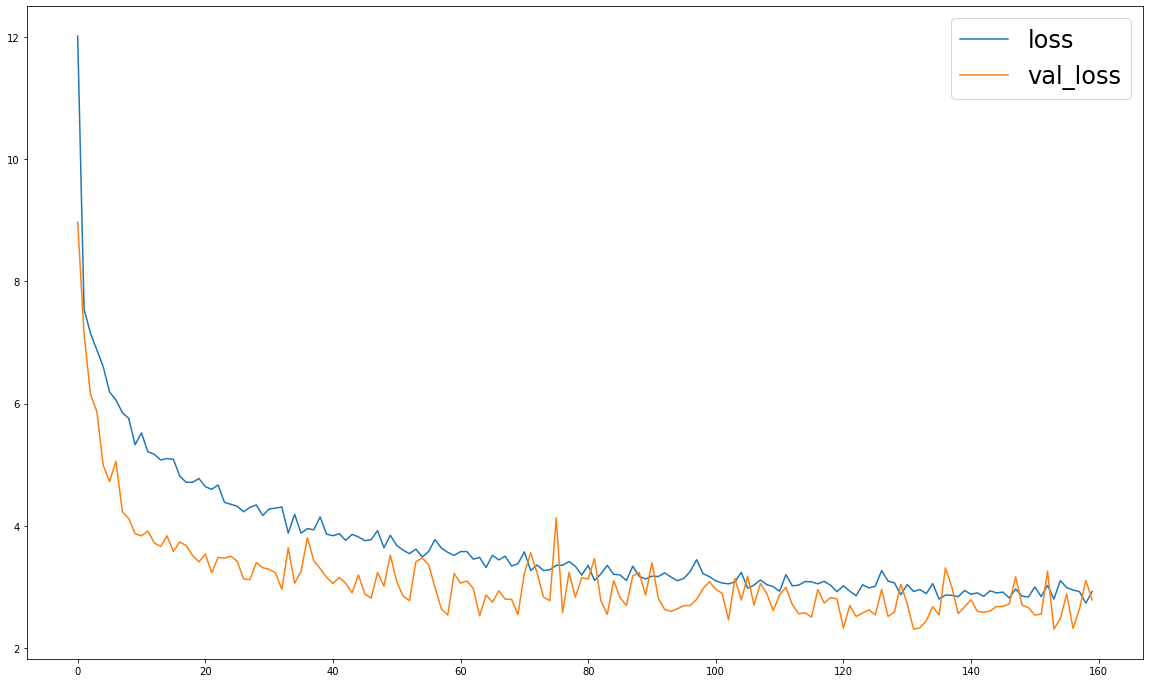

In [10]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

## 6. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator that we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [11]:
# 1: Set the generator for the predictions.
val_labels_filename = "./data/val_annos.csv"
val_images_dir = '../BlazeFace/data/WIDER_val/images/'
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path='wider_val_new_v2.h5')
val_dataset.parse_csv(images_dir=val_images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')
resize = Resize(height=img_height, width=img_width)
convert_to_3_channels = ConvertTo3Channels()
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

Loading images into memory: 100%|██████████| 3226/3226 [00:54<00:00, 59.00it/s]


In [33]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

# print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


Ground truth boxes:

[[  1. 386. 172. 556. 388.]]


In [34]:
# 3: Make predictions.

y_pred = model.predict(batch_images)

Now let's decode the raw predictions in `y_pred`.

Had we created the model in 'inference' or 'inference_fast' mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in 'training' mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.

In [35]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

We made the predictions on the resized images, but we'd like to visualize the outcome on the original input images, so we'll convert the coordinates accordingly. Don't worry about that opaque `apply_inverse_transforms()` function below, in this simple case it just aplies `(* original_image_size / resized_image_size)` to the box coordinates.

In [36]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)
i= 0
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.94 416.   129.   586.   308.  ]
 [  1.     0.6  232.   164.   395.   319.  ]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

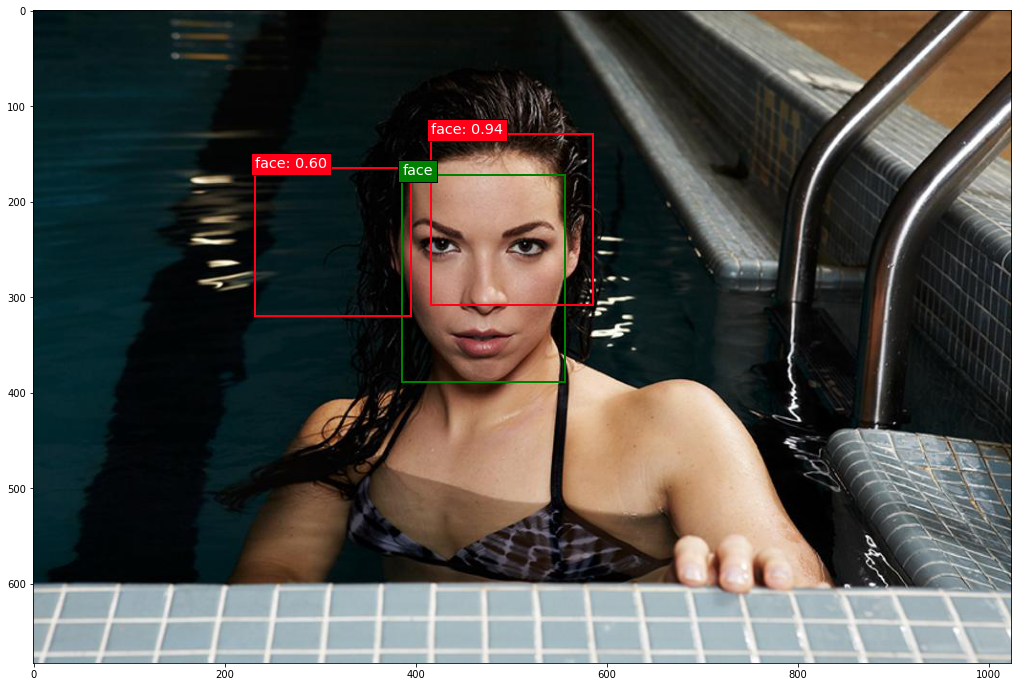

In [37]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'face']
i = 0
plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})